# Configs

In [1]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [2]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# LSTM

### Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    def __init__(self, inSize):
        super(LSTMModel, self).__init__()

        self.inSize = inSize

        self.lstm = nn.LSTM(
            input_size=inSize, hidden_size=64, batch_first=True, dropout=0.5
        )
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze(2)
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)

        return x

### Train and eval

In [4]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.dl_train_test import infer, train
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            pin_memory=True,
            shuffle=False,
        )

        model = LSTMModel(inSize=npTrainX.shape[2])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model,
            device,
            trainLoader,
            valLoader,
            criterion,
            optimizer,
            epochs=50,
            earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = infer(model, device, testLoader)
        probas.append(predProbas.detach().cpu().numpy())
        torch.save(model.state_dict(), f"result/lstm_only_model/{i}_{ii}.pt")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/50 Train Loss: 0.6560 Val Loss: 0.7825
Epoch 2/50 Train Loss: 0.6234 Val Loss: 0.7744
Epoch 3/50 Train Loss: 0.5890 Val Loss: 0.7652
Epoch 4/50 Train Loss: 0.5612 Val Loss: 0.7557
Epoch 5/50 Train Loss: 0.5351 Val Loss: 0.7433
Epoch 6/50 Train Loss: 0.5095 Val Loss: 0.7342
Epoch 7/50 Train Loss: 0.4916 Val Loss: 0.7331
Epoch 8/50 Train Loss: 0.4824 Val Loss: 0.7312
Epoch 9/50 Train Loss: 0.4804 Val Loss: 0.7336
Epoch 10/50 Train Loss: 0.4751 Val Loss: 0.7335
Epoch 11/50 Train Loss: 0.4654 Val Loss: 0.7276
Epoch 12/50 Train Loss: 0.4616 Val Loss: 0.7295
Epoch 13/50 Train Loss: 0.4535 Val Loss: 0.7319
Epoch 14/50 Train Loss: 0.4514 Val Loss: 0.7316
Epoch 15/50 Train Loss: 0.4394 Val Loss: 0.7279
Epoch 16/50 Train Loss: 0.4329 Val Loss: 0.7287
Epoch 17/50 Train Loss: 0.4241 Val Loss: 0.7297
Epoch 18/50 Train Loss: 0.4180 Val Loss: 0.7305
Epoch 19/50 Train Loss: 0.4116 Val Loss: 0.7303
Epoch 20/50 Train Loss: 0.4149 Val Loss: 0.7297
Epoch 21/50 Train Loss: 0.4142 Val Loss: 0.7237
E

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 7/50 Train Loss: 0.5040 Val Loss: 0.7176
Epoch 8/50 Train Loss: 0.5015 Val Loss: 0.7182
Epoch 9/50 Train Loss: 0.4871 Val Loss: 0.7127
Epoch 10/50 Train Loss: 0.4833 Val Loss: 0.7146
Epoch 11/50 Train Loss: 0.4731 Val Loss: 0.7151
Epoch 12/50 Train Loss: 0.4683 Val Loss: 0.7110
Epoch 13/50 Train Loss: 0.4653 Val Loss: 0.7132
Epoch 14/50 Train Loss: 0.4609 Val Loss: 0.7116
Epoch 15/50 Train Loss: 0.4504 Val Loss: 0.7115
Epoch 16/50 Train Loss: 0.4433 Val Loss: 0.7083
Epoch 17/50 Train Loss: 0.4260 Val Loss: 0.7103
Epoch 18/50 Train Loss: 0.4232 Val Loss: 0.7076
Epoch 19/50 Train Loss: 0.4076 Val Loss: 0.7130
Epoch 20/50 Train Loss: 0.4116 Val Loss: 0.7089
Epoch 21/50 Train Loss: 0.3999 Val Loss: 0.7039
Epoch 22/50 Train Loss: 0.3806 Val Loss: 0.7063
Epoch 23/50 Train Loss: 0.3717 Val Loss: 0.7068
Epoch 24/50 Train Loss: 0.3531 Val Loss: 0.7047
Epoch 25/50 Train Loss: 0.3530 Val Loss: 0.7071
Epoch 26/50 Train Loss: 0.3375 Val Loss: 0.7077
Epoch 27/50 Train Loss: 0.3326 Val Loss: 0.

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/50 Train Loss: 0.6921 Val Loss: 0.7949
Epoch 2/50 Train Loss: 0.6563 Val Loss: 0.7887
Epoch 3/50 Train Loss: 0.6259 Val Loss: 0.7791
Epoch 4/50 Train Loss: 0.5868 Val Loss: 0.7675
Epoch 5/50 Train Loss: 0.5502 Val Loss: 0.7574
Epoch 6/50 Train Loss: 0.5132 Val Loss: 0.7487
Epoch 7/50 Train Loss: 0.5000 Val Loss: 0.7436
Epoch 8/50 Train Loss: 0.4771 Val Loss: 0.7370
Epoch 9/50 Train Loss: 0.4590 Val Loss: 0.7360
Epoch 10/50 Train Loss: 0.4653 Val Loss: 0.7365
Epoch 11/50 Train Loss: 0.4532 Val Loss: 0.7332
Epoch 12/50 Train Loss: 0.4476 Val Loss: 0.7358
Epoch 13/50 Train Loss: 0.4347 Val Loss: 0.7308
Epoch 14/50 Train Loss: 0.4348 Val Loss: 0.7367
Epoch 15/50 Train Loss: 0.4214 Val Loss: 0.7374
Epoch 16/50 Train Loss: 0.4204 Val Loss: 0.7371
Epoch 17/50 Train Loss: 0.4041 Val Loss: 0.7342
Epoch 18/50 Train Loss: 0.3930 Val Loss: 0.7342
Epoch 19/50 Train Loss: 0.3916 Val Loss: 0.7320
Epoch 20/50 Train Loss: 0.3927 Val Loss: 0.7354
Epoch 21/50 Train Loss: 0.3819 Val Loss: 0.7301
E

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 8/50 Train Loss: 0.4803 Val Loss: 0.7416
Epoch 9/50 Train Loss: 0.4761 Val Loss: 0.7397
Epoch 10/50 Train Loss: 0.4612 Val Loss: 0.7392
Epoch 11/50 Train Loss: 0.4648 Val Loss: 0.7321
Epoch 12/50 Train Loss: 0.4510 Val Loss: 0.7381
Epoch 13/50 Train Loss: 0.4484 Val Loss: 0.7392
Epoch 14/50 Train Loss: 0.4397 Val Loss: 0.7325
Epoch 15/50 Train Loss: 0.4388 Val Loss: 0.7336
Epoch 16/50 Train Loss: 0.4274 Val Loss: 0.7358
Epoch 17/50 Train Loss: 0.4188 Val Loss: 0.7311
Epoch 18/50 Train Loss: 0.4216 Val Loss: 0.7323
Epoch 19/50 Train Loss: 0.4221 Val Loss: 0.7336
Epoch 20/50 Train Loss: 0.4151 Val Loss: 0.7329
Epoch 21/50 Train Loss: 0.4179 Val Loss: 0.7343
Epoch 22/50 Train Loss: 0.4174 Val Loss: 0.7323
Epoch 23/50 Train Loss: 0.4174 Val Loss: 0.7321
Epoch 24/50 Train Loss: 0.4191 Val Loss: 0.7321
Epoch 25/50 Train Loss: 0.4156 Val Loss: 0.7318
Epoch 26/50 Train Loss: 0.4108 Val Loss: 0.7327
Epoch 27/50 Train Loss: 0.4152 Val Loss: 0.7333
Epoch 28/50 Train Loss: 0.4151 Val Loss: 0

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 4/50 Train Loss: 0.5766 Val Loss: 0.7656
Epoch 5/50 Train Loss: 0.5380 Val Loss: 0.7523
Epoch 6/50 Train Loss: 0.5171 Val Loss: 0.7398
Epoch 7/50 Train Loss: 0.5022 Val Loss: 0.7379
Epoch 8/50 Train Loss: 0.4949 Val Loss: 0.7403
Epoch 9/50 Train Loss: 0.4711 Val Loss: 0.7363
Epoch 10/50 Train Loss: 0.4669 Val Loss: 0.7332
Epoch 11/50 Train Loss: 0.4633 Val Loss: 0.7307
Epoch 12/50 Train Loss: 0.4563 Val Loss: 0.7284
Epoch 13/50 Train Loss: 0.4538 Val Loss: 0.7314
Epoch 14/50 Train Loss: 0.4424 Val Loss: 0.7277
Epoch 15/50 Train Loss: 0.4361 Val Loss: 0.7250
Epoch 16/50 Train Loss: 0.4304 Val Loss: 0.7285
Epoch 17/50 Train Loss: 0.4200 Val Loss: 0.7250
Epoch 18/50 Train Loss: 0.4125 Val Loss: 0.7243
Epoch 19/50 Train Loss: 0.4137 Val Loss: 0.7238
Epoch 20/50 Train Loss: 0.3909 Val Loss: 0.7263
Epoch 21/50 Train Loss: 0.3927 Val Loss: 0.7179
Epoch 22/50 Train Loss: 0.3757 Val Loss: 0.7197
Epoch 23/50 Train Loss: 0.3628 Val Loss: 0.7231
Epoch 24/50 Train Loss: 0.3558 Val Loss: 0.718

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 7/50 Train Loss: 0.5015 Val Loss: 0.7435
Epoch 8/50 Train Loss: 0.4853 Val Loss: 0.7398
Epoch 9/50 Train Loss: 0.4823 Val Loss: 0.7390
Epoch 10/50 Train Loss: 0.4697 Val Loss: 0.7346
Epoch 11/50 Train Loss: 0.4571 Val Loss: 0.7359
Epoch 12/50 Train Loss: 0.4503 Val Loss: 0.7384
Epoch 13/50 Train Loss: 0.4462 Val Loss: 0.7307
Epoch 14/50 Train Loss: 0.4375 Val Loss: 0.7275
Epoch 15/50 Train Loss: 0.4319 Val Loss: 0.7317
Epoch 16/50 Train Loss: 0.4235 Val Loss: 0.7321
Epoch 17/50 Train Loss: 0.4232 Val Loss: 0.7343
Epoch 18/50 Train Loss: 0.4145 Val Loss: 0.7333
Epoch 19/50 Train Loss: 0.4061 Val Loss: 0.7328
Epoch 20/50 Train Loss: 0.4049 Val Loss: 0.7292
Epoch 21/50 Train Loss: 0.3964 Val Loss: 0.7315
Epoch 22/50 Train Loss: 0.3979 Val Loss: 0.7334
Epoch 23/50 Train Loss: 0.3934 Val Loss: 0.7293
Epoch 24/50 Train Loss: 0.3915 Val Loss: 0.7292
Epoch 25/50 Train Loss: 0.3941 Val Loss: 0.7292
Epoch 1/50 Train Loss: 0.6709 Val Loss: 0.7838
Epoch 2/50 Train Loss: 0.6369 Val Loss: 0.77

In [5]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.812433763126126 +- 0.02091477100428134 [np.float64(0.8259201116343973), np.float64(0.775946275946276), np.float64(0.8259060169932374), np.float64(0.8321484307265476), np.float64(0.802247980330172)]
Accuracy: 0.7615595238095237 +- 0.02334376319104045 [0.7866666666666666, 0.72, 0.7688888888888888, 0.7777777777777778, 0.7544642857142857]
Specificity: 0.814164569937564 +- 0.030577930510769156 [np.float64(0.8639455782312925), np.float64(0.7959183673469388), np.float64(0.8356164383561644), np.float64(0.7876712328767124), np.float64(0.7876712328767124)]
Precision: 0.6577840982546864 +- 0.03881546863230747 [0.7142857142857143, 0.6, 0.68, 0.6593406593406593, 0.6352941176470588]
Recall: 0.6630639402791301 +- 0.06060672600383502 [0.6410256410256411, 0.5769230769230769, 0.6455696202531646, 0.759493670886076, 0.6923076923076923]
AUC PR: 0.683007696030965 +- 0.02154147773926118 [np.float64(0.6968695331756796), np.float64(0.6461308097797042), np.float64(0.6851803363777984), np.float64(0.709954

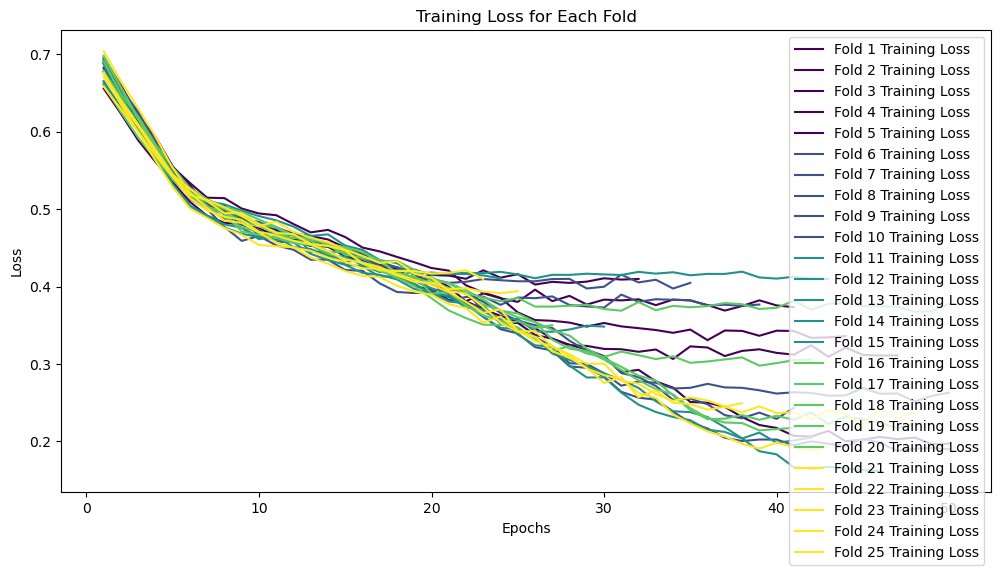

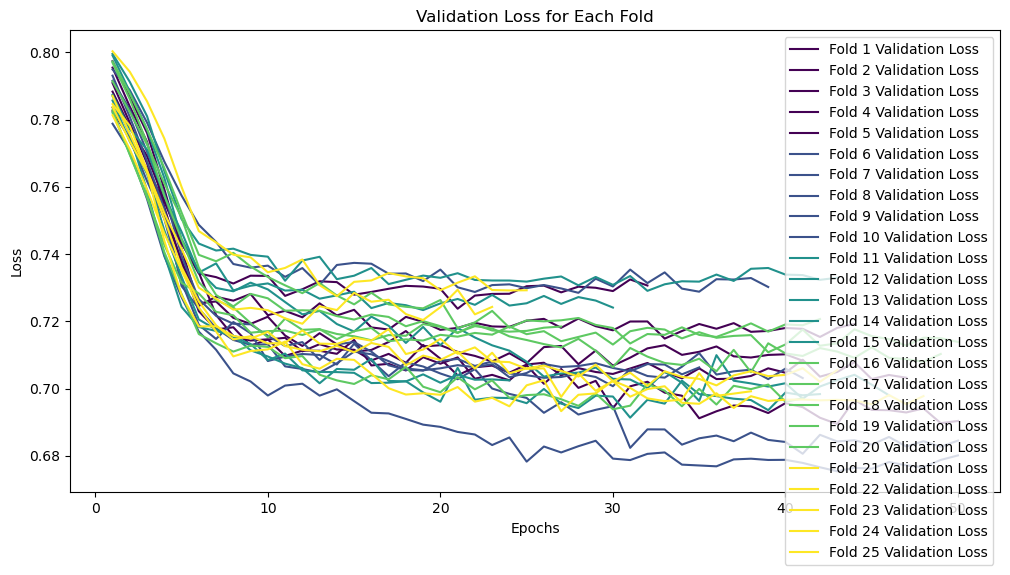

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_val_loss.svg")
plt.show()